# test whether NCA can learn the square from forward training

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models.embeddings import TimestepEmbedding

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


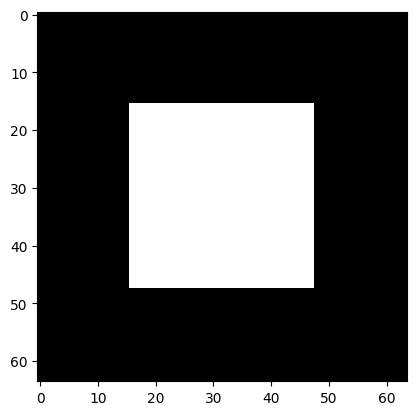

In [35]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
#image = torch.zeros((1, 1, image_size, image_size), device=device)
image = torch.full((1, 1, image_size, image_size), 0.2, device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

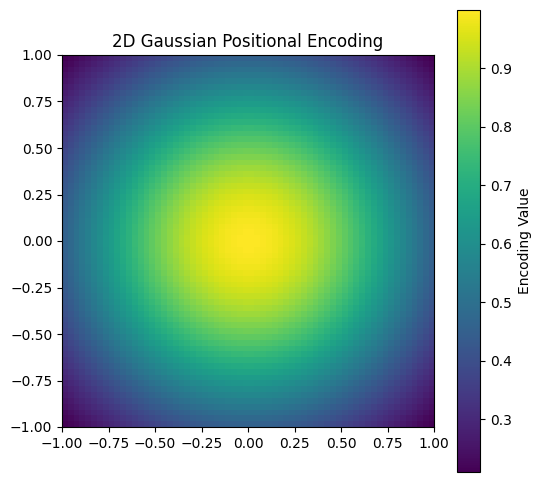

In [92]:
# Define image size
H, W = 64, 64  # Height and Width

# Create coordinate grids
x = torch.linspace(-1, 1, W).repeat(H, 1)
y = torch.linspace(-1, 1, H).repeat(W, 1).T

# Define Gaussian parameters (center at (0,0) and standard deviation)
mu_x, mu_y = 0.0, 0.0  # Center of the Gaussian
sigma_x, sigma_y = 0.8, 0.8  # Spread

# Compute 2D Gaussian
positional_encoding = torch.exp(-((x - mu_x) ** 2 / (2 * sigma_x ** 2) + (y - mu_y) ** 2 / (2 * sigma_y ** 2))).to(device)

# Convert to numpy for visualization
positional_encoding_np = positional_encoding.cpu().numpy()

# Plot the positional encoding
plt.figure(figsize=(6,6))
plt.imshow(positional_encoding_np, cmap='viridis', extent=[-1,1,-1,1])
plt.colorbar(label='Encoding Value')
plt.title("2D Gaussian Positional Encoding")
plt.show()

# for later user
positional_encoding = positional_encoding.unsqueeze(0).unsqueeze(0)


In [88]:
class NCAD(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCAD, self).__init__()

        #Positional Encoding now added (+1)
        self.inchannels = in_channels + 1
        self.outchannels = out_channels
        channelWidth = 16

        
        self.conv1 = nn.Conv2d(self.inchannels, channelWidth, kernel_size=3, padding=1, groups=self.inchannels)  # 3x3 convolution
        self.conv2 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1)
        self.conv3 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(channelWidth, out_channels, kernel_size=1) # 1x1 convolution

        self.cell_fire_rate = 0.5
        #self.stepsize = 0.1        

    def forward(self, inp, t):
        bs, ch, height, width = inp.shape

        x = F.relu(self.conv1(inp))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)

        # Stochastic update mask from ' ? Check link in mail
        if self.training:
            updateMask = (
                torch.clamp(torch.rand_like(x, device=x.device), 0.0, 1.0).float()
                < self.cell_fire_rate
            ).float()
            x = x * updateMask

        #x[0, 0] = inp[0, 0] + x[0, 0] * self.stepsize 

        return inp[:, 0:self.outchannels, :, :] + x 
    
    def infer(self, x, steps, t):
        for i in range(steps):
            x = self.forward(x, t)
            # alpha_bar = self.get_alpha_bar(i, steps)  # Compute cumulative alpha_bar for step i
            # x = (alpha_bar ** 0.5) * x + ((1 - alpha_bar) ** 0.5) * self.forward(x, t)
        return x

In [89]:
twoModel = NCAD(3, 3).to(device)

losses = {}

Op = torch.optim.Adam(twoModel.parameters(), lr=1e-4)
diffusionSteps = 32 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

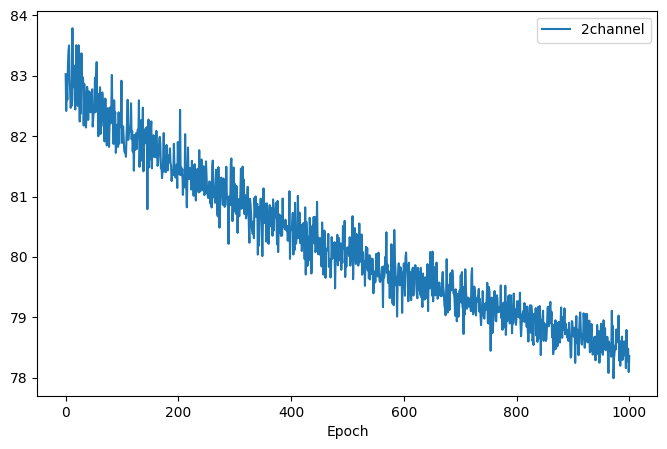

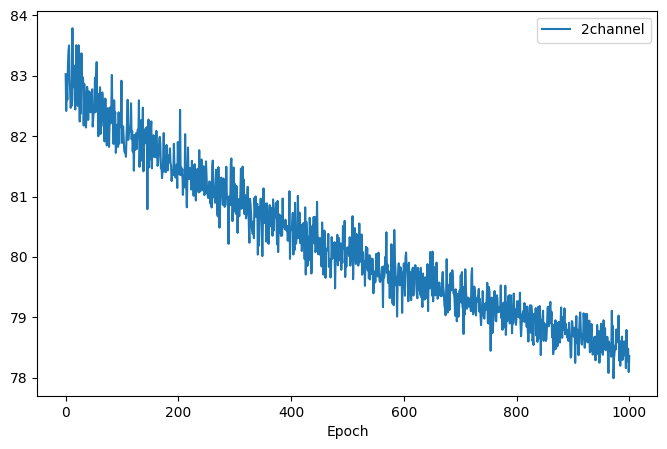

In [96]:
def trainModelForward(model, channels, lossDict, id, ncaSteps, epochs, optimizer, target):
    global positional_encoding
    model.train()
    criterion = nn.MSELoss(reduction='sum')
    batchSize = 32
    target = target.expand(batchSize, -1, -1, -1)
    pos_encoding = positional_encoding.expand(batchSize, -1, -1, -1)

    fig, ax = plt.subplots(figsize=(8, 5))
    display(fig)
    lossDict[id] = []

    for epoch in range(epochs):
        optimizer.zero_grad()
    
        imageX = torch.zeros((batchSize, channels, 64, 64), device=device)
        noise = (torch.rand((batchSize, 1, 64, 64), device=device) + 0.5).clamp(0, 1)
        imageX[:, 0:1, :, :] = noise

        for i, t in enumerate(scheduler.timesteps):
            timeTensor = torch.tensor([t]).float().to(device)     

            #Channels aren't well defined
            #Adding an extra channel as a positional conditioning?
            imageX = torch.cat((imageX, pos_encoding), dim=1)
            
            modelOut = model.infer(imageX, ncaSteps, timeTensor)
            #imageX = scheduler.step(modelOut, t, imageX).prev_sample
            imageX = modelOut

        Loss = criterion(torch.sigmoid(imageX[:, 0:1, :, :]), target)
        Loss.backward()
        optimizer.step()

        lossDict[id].append(Loss.item() / batchSize)
        #if epoch % 100 == 0:
        clear_output(wait=True)  
        ax.clear()
        #plt.plot(losses["timeModel"][1000:], label=f'timeModel')
        plt.plot(lossDict[id][:], label=id)
        plt.legend()
        plt.xlabel('Epoch')
        display(fig)

    return model, losses

twoModel, losses = trainModelForward(twoModel, 3, losses, '2channel', 1, 1001, Op, image)

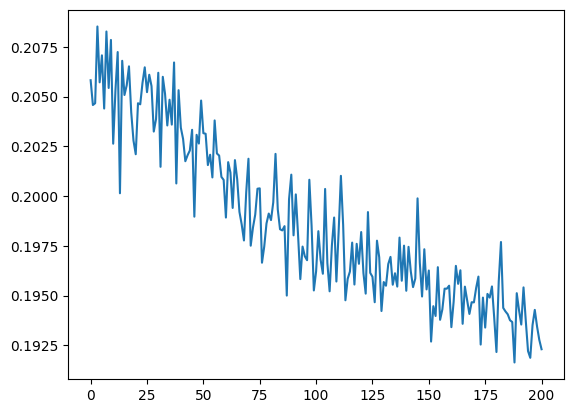

In [72]:
plt.plot(losses["2channel"][800:])

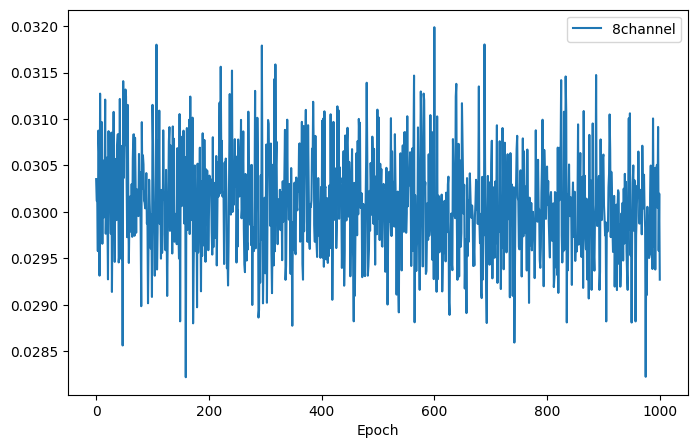

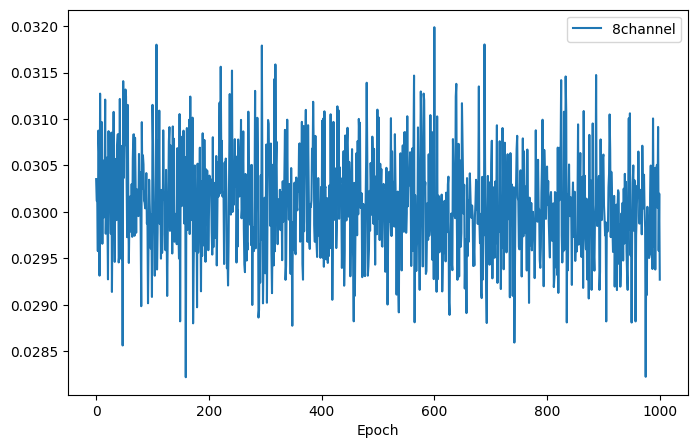

In [124]:
# eightModel = NCAD(8, 8).to(device)

# Op = torch.optim.Adam(eightModel.parameters(), lr=1e-4)

eightModel, losses = trainModelForward(eightModel, 8, losses, '8channel', 1, 1001, Op, image)

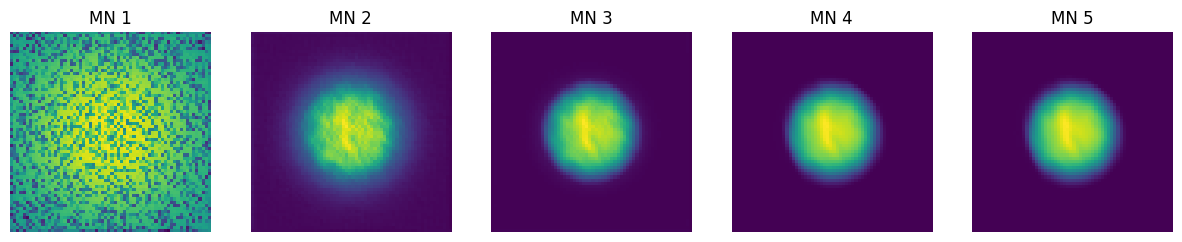

In [107]:
# Inference of trained models 
evaluatedModel = twoModel
modelChannels = 3
ncaSteps = 1
usePositionalEncoding = True

evaluatedModel.eval()
inferenceSteps = 32
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    # x = torch.zeros((1, modelChannels, 64, 64)).to(device)
    # x[0, 0] = torch.randn((64,64))

    x = torch.zeros((1, modelChannels, 64, 64), device=device)
    x[0, 0] = (torch.rand((64, 64), device=device) + 0.5).clamp(0, 1)

    intermediateImages = []

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)

        if usePositionalEncoding:
            x = torch.cat((x, positional_encoding), dim=1)

        x = evaluatedModel.infer(x, ncaSteps, timeTensor)

        if i % 10  == 0:
            intermediateImages.append(x.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages.append(x.cpu().numpy())

numColumns = len(intermediateImages)
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for col, img in enumerate(intermediateImages):
    axs[ col].imshow(img[0,0])
    axs[ col].axis('off')  
    axs[ col].set_title(f"{'MN'} {col+1}")  
